This is model, where we should do binary classification - predict probability of A

   1) num_classes - number of classes
   
   2) each class has its popability of A
   
   3) prob - array of these probabilities; they are Q - coordinates for Hamiltonian MCMC
   
   4) prior (alpha, beta) are two float variables describing beta-distribution classes' popabilities.

In [1]:
%matplotlib inline

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import pandas as pd
import warnings
from matplotlib import pyplot as plt
import collections

import tensorflow as tf
import tensorflow_probability as tfp
from IPython.display import clear_output

tfd = tfp.distributions

/home/aapopovkin/venv/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/aapopovkin/venv/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/aapopovkin/venv/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/aapopovkin/venv/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/aapopovkin/venv/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
def reset_tf():
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        tf.reset_default_graph()
        try:
            sess.close()
        except:
            pass
        sess = tf.InteractiveSession()
        
    return sess

In [3]:
def get_example_data():
    ps_data_arr = np.array([
        [20, 10, 1, 0.499993], [20, 3, 2, 0.230211], [20, 8, 3, 0.236831], 
        [20, 7, 4, 0.246463], [20, 6, 5, 0.370862], [20, 5, 6, 0.320656], 
        [20, 10, 7, 0.519887], [20, 12, 8, 0.52845], [20, 8, 9, 0.453077], 
        [20, 8, 10, 0.431245], [20, 10, 11, 0.499243], [20, 9, 12, 0.471968], 
        [20, 2, 13, 0.152176], [20, 14, 14, 0.48496], [20, 6, 15, 0.246193]
    ])
    ps_data_pd=pd.DataFrame(data=ps_data_arr[0:, 0:],
             index=ps_data_arr[0:, 2],
             columns=["total_count", "clicks", "class_id", "true_p"],
             dtype=np.float32)
    ps_data_pd['class_id'] = ps_data_pd.class_id.astype('int32')
    
    return ps_data_pd

In [4]:
def sample_data(classes=15, alpha=1, beta=10, samples=20):
    p = np.random.beta(alpha, beta, size=classes)
    clicks = np.random.binomial(samples, p)
    
    ps_data_arr = np.array([
        [samples, clicks[i], i + 1, p[i]] for i in range(classes)
    ])
    
    ps_data_pd=pd.DataFrame(data=ps_data_arr[0:, 0:],
             index=ps_data_arr[0:, 2],
             columns=["total_count", "clicks", "class_id", "true_p"],
             dtype=np.float32)
    ps_data_pd['class_id'] = ps_data_pd.class_id.astype('int32')
    
    return ps_data_pd

In [30]:
def approximate_alpha_and_beta(ps_data_pd):
    
    sess = reset_tf()

    inv_alpha_transform = lambda y: np.log(y)  # Not using TF here.
    fwd_alpha_transform = tf.exp

    def _make_ps_prior(num_classes, dtype):
        raw_prior_alpha = tf.get_variable(
          name='raw_prior_alpha',
          initializer=np.array(inv_alpha_transform(5.), dtype=dtype))
        raw_prior_beta = tf.get_variable(
          name='raw_prior_beta',
          initializer=np.array(inv_alpha_transform(5.), dtype=dtype))   
        return tfd.Independent(
          tfd.Beta(
              fwd_alpha_transform(raw_prior_alpha) * tf.ones(num_classes),
              fwd_alpha_transform(raw_prior_beta) * tf.ones(num_classes) * 10),
          reinterpreted_batch_ndims=-1)#1)

    def _make_ps_log_likelihood(prob, class_id, total_count):
        prob_c = tf.gather(prob, indices=tf.to_int32(class_id - 1), axis=-1)
        total_count_c = tf.gather(total_count, indices=tf.to_int32(class_id - 1), axis=-1)
        return tfp.distributions.Binomial(total_count=tf.to_float(total_count_c), probs=prob_c)
    
    make_ps_prior = tf.make_template(name_='make_ps_prior', func_=_make_ps_prior)
    make_ps_log_likelihood = tf.make_template(name_='make_ps_log_likelihood', func_=_make_ps_log_likelihood)
    
    def joint_log_prob(prob, total_count, clicks, class_id, dtype):
        num_classes = len(total_count)
        rv_prob = make_ps_prior(num_classes, dtype)
        rv_clicks = make_ps_log_likelihood(prob, class_id, total_count)
        return (rv_prob.log_prob(prob) + 
             tf.reduce_sum(rv_clicks.log_prob(clicks), axis=-1))
    
    dtype = np.float32
    def unnormalized_posterior_log_prob(prob):
        return joint_log_prob(
            prob=tf.sigmoid(prob),
            total_count=dtype(ps_data_pd.total_count.values),
            clicks=dtype(ps_data_pd.clicks.values),
            class_id=np.int32(ps_data_pd.class_id.values),
            dtype=dtype)

    step_size = tf.get_variable(
        'step_size',
        initializer=0.01,
        trainable=False)

    hmc = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        num_leapfrog_steps=10,
        step_size=step_size,#0.01,
        step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(target_rate=0.75),
        state_gradients_are_stopped=True)

    init_random_weights = tf.placeholder(dtype, shape=[len(ps_data_pd)])

    posterior_random_weights, kernel_results = tfp.mcmc.sample_chain(
        num_results=3,
        num_burnin_steps=0,
        num_steps_between_results=0,
        current_state=init_random_weights,
        kernel=hmc)

    loss = -tf.reduce_mean(kernel_results.accepted_results.target_log_prob)

    global_step = tf.train.get_or_create_global_step()

    learning_rate = tf.train.exponential_decay(
        learning_rate=0.1,
        global_step=global_step,
        decay_steps=2,
        decay_rate=0.9995)

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss, global_step=global_step)

    init_op = tf.initialize_all_variables()
    with tf.variable_scope('make_ps_prior', reuse=True):
        prior_alpha = fwd_alpha_transform(tf.get_variable(
            name='raw_prior_alpha', dtype=dtype))
        prior_beta = fwd_alpha_transform(tf.get_variable(
            name='raw_prior_beta', dtype=dtype))

    init_op.run()
    w_ = 0.5 * np.ones([len(ps_data_pd)], dtype=dtype)
    
    maxiter = int(3000)
    num_accepted = 0
    num_drawn = 0
    alphas = []
    betas = []
    for i in range(maxiter):
        [
          _,
          global_step_,
          loss_,
          posterior_random_weights_,
          kernel_results_,
          step_size_,
          prior_alpha_,
          prior_beta_,
          #raw_prior_alpha_,
          #raw_prior_beta_
        ] = sess.run([
          train_op,
          global_step,
          loss,
          posterior_random_weights,
          kernel_results,
          step_size,
          prior_alpha,
          prior_beta,
          #tf.get_variable(name='raw_prior_alpha'),
          #tf.get_variable(name='raw_prior_beta')
        ], feed_dict={init_random_weights: w_})
        
        w_ = posterior_random_weights_[-1, :]
        num_accepted += kernel_results_.is_accepted.sum()
        num_drawn += kernel_results_.is_accepted.size
        acceptance_rate = num_accepted / num_drawn
        if i > 500 or True:
            alphas.append(prior_alpha_)
            betas.append(prior_beta_)
        
        if i % 100 == 0 or i == maxiter - 1 or \
            loss_.mean() != loss_.mean() or \
            prior_alpha_ != prior_alpha_ or \
            prior_beta_ != prior_beta_ \
            : 
            clear_output()
            print('global_step:{:>4}  loss:{: 7.1f}  acceptance:{:.3f}  '
                  'step_size:{:.3f}  prior_alpha:{:.4f}  prior_beta:{:.4f}'.format(
                      global_step_, loss_.mean(),
                      acceptance_rate, step_size_,
                      prior_alpha_, prior_beta_)
            )
            print (kernel_results_.proposed_state)
            plt.plot(alphas)
            plt.plot(np.array(betas) * 10)
            plt.grid()
            plt.show()
            if loss_.mean() != loss_.mean() or \
                prior_alpha_ != prior_alpha_ or \
                prior_beta_ != prior_beta_ \
                :
                print (global_step_,
                      loss_,
                      posterior_random_weights_,
                      kernel_results_,
                      step_size_,
                      prior_alpha_,
                      prior_beta_,
                      sep="\n--------\n")
                print ("-" * 50)
                print (global_step___,
                      loss___,
                      posterior_random_weights___,
                      kernel_results___,
                      step_size___,
                      prior_alpha___,
                      prior_beta___,
                      sep="\n--------\n")
                return None, None
                
        [
          _,
          global_step___,
          loss___,
          posterior_random_weights___,
          kernel_results___,
          step_size___,
          prior_alpha___,
          prior_beta___
        ] = [
          _,
          global_step_,
          loss_,
          posterior_random_weights_,
          kernel_results_,
          step_size_,
          prior_alpha_,
          prior_beta_
        ]
    return prior_alpha_, prior_beta_

global_step: 219  loss:    nan  acceptance:0.673  step_size:0.029  prior_alpha:nan  prior_beta:nan
[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]]


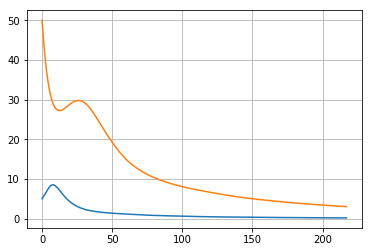

219
--------
nan
--------
[[ -3.2583332  -16.29046     -0.26232782  -6.843421   -15.378631
  -13.667314    -3.579461    -3.4989984  -14.338581    -7.8666797
  -10.222091   -13.214819    -9.8136425   -0.8443723   -0.3600217 ]
 [ -3.2583332  -16.29046     -0.26232782  -6.843421   -15.378631
  -13.667314    -3.579461    -3.4989984  -14.338581    -7.8666797
  -10.222091   -13.214819    -9.8136425   -0.8443723   -0.3600217 ]
 [ -3.2583332  -16.29046     -0.26232782  -6.843421   -15.378631
  -13.667314    -3.579461    -3.4989984  -14.338581    -7.8666797
  -10.222091   -13.214819    -9.8136425   -0.8443723   -0.3600217 ]]
--------
MetropolisHastingsKernelResults(accepted_results=UncalibratedHamiltonianMonteCarloKernelResults(log_acceptance_correction=array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32), target_log_prob

In [31]:
for i in range(100):
    alpha = 1 + np.random.randint(10)
    beta = 10 + np.random.randint(100)
    a, b = approximate_alpha_and_beta(sample_data(alpha=alpha, beta=beta))
    if a is None:
        break